<h2>OBSERVATIONAL ASTROPHYSICS – FALL 2019 Reduction Exercise: Part 5</h2>

The goal of this part is to produce a color-magnitude diagram for your cluster.  Do do this we need to detect stars, measure their flux, compare it to a known magnitude for that star, derive the magnitude zeropoint for that band, and convert all of your fluxes to magnitudes.  This will be broked into the following steps:

1. read in image with a valid astrometric header (the output image from the end of part 4);
2. Locate stars in this image and measure their flux;
3. Read in an ASCII file with a list of measured magnitudes for stars in that cluster;
4. Cross-match the two lists to find which object corresponds to which;
5. Compare the fluxes and magnitudes to determine the magnitude zeropoint of your image, i.e. what magnitude is a single count;
6. Use this to create magnitudes in each band
7. Produce a color-magnitude diagrame

The first cell below is a routine designed to read in one image

In [3]:
import os, glob, time
import numpy as np
from astropy.io import fits
from matplotlib import pyplot as plt

redpath = "/home/c827f144/RFSLAB/USER_DPT/c827f144/ASTR596/Data/Reduced/20191104/"

A routine to display in image

In [4]:
def display_image(img, minclip=5, maxclip=95, label=None, cmap='Greys_r', 
                  srcs=None, projection=None, calibrated=False):
    """Simple wrapper to display an image.
    
    """
    from astropy.visualization import AsinhStretch as Stretch
    from astropy.visualization import ZScaleInterval as Interval
    from astropy.visualization.mpl_normalize import ImageNormalize

    #from astropy.visualization import simple_norm
    #norm = simple_norm(img, min_percent=minclip, max_percent=maxclip)

    interval = Interval(contrast=0.5)
    vmin, vmax = interval.get_limits(img)
    norm = ImageNormalize(interval=interval, stretch=Stretch(a=0.9))

    fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={'projection': projection})
    im = ax.imshow(img, origin='lower', norm=norm, cmap=cmap,
                   vmin=vmin, vmax=vmax)
    if projection:
        ax.coords.grid(color='red')
        ax.coords['ra'].set_axislabel('Right Ascension')
        ax.coords['dec'].set_axislabel('Declination')      
    else:
        ax.set_xlabel('Column Number (pixels)')
        ax.set_ylabel('Row Number (pixels)')

    # Mark the locations of stars.
    if srcs:
        from photutils import CircularAperture
        pos = np.transpose((srcs['xcentroid'], srcs['ycentroid']))
        aps = CircularAperture(pos, r=12.)
        aps.plot(color='red', lw=1.5, alpha=0.6, axes=ax)
      
    # Make room for the colorbar
    fig.subplots_adjust(right=0.8)
    cax = fig.add_axes([0.85, 0.28, 0.05, 0.45])
    c = plt.colorbar(im, cax=cax)
    if label:
        c.set_label(label)
    else:
        if calibrated:
            c.set_label(r'Intensity ($e^{-}/s$)')
        else:
            c.set_label('Intensity (ADU)')

<h3> Find the stars in your image</h3>

In [5]:
#filename should be the name of the combined image file (without path) that has the original header
#wcsfilename should be the name of the image that has the correct WCS header, e.g. one output
#by astrometry.net. 
def read_one_image(filename, wcsfilename, redpath):
    from astropy.table import Table
    from astropy.wcs import WCS

    # This joins the path and the filename
    imgfile = os.path.join('{}'.format(redpath), filename)
    wcsfile = os.path.join('{}'.format(redpath), wcsfilename)

    print('Reading {}'.format(imgfile))
    #this is the image and full header of the file.  
    img, hdr = fits.getdata(imgfile, header=True)
    wcshdr = fits.getheader(wcsfile)

    #this is only the section of the file that contains the WCS, which is the mapping between pixel 
    #and sky coordinate (RA,DEC)
    imgwcs = WCS(wcshdr)#, naxis=2)

    return img, hdr, imgwcs, imgfile

In [6]:
img_king20_V, hdr_king20_V, imgwcs_king20_V, imgfile_king20_V = read_one_image('king20_V_comb.fits','wking20_V_comb.fits',redpath)
img_king20_B, hdr_king20_B, imgwcs_king20_B, imgfile_king20_B = read_one_image('king20_B_comb.fits','wking20_B_comb.fits',redpath)

Reading /home/c827f144/RFSLAB/USER_DPT/c827f144/ASTR596/Data/Reduced/20191104/king20_V_comb.fits
Reading /home/c827f144/RFSLAB/USER_DPT/c827f144/ASTR596/Data/Reduced/20191104/king20_B_comb.fits


This is the same routine that we used in part 4.  It measures the background.

In [7]:
def get_sky_background(img, verbose=True):
    from astropy.stats import SigmaClip
    from photutils import Background2D, MedianBackground
    sigma_clip = SigmaClip(sigma=4.)
    bkg = Background2D(img, (100, 100), filter_size=(10, 10), sigma_clip=sigma_clip, 
                       bkg_estimator=MedianBackground())
    if verbose:
        print('Sky background median = {:.3f}, rms = {:.3f} electrons.'.format(bkg.background_median, bkg.background_rms_median))
    return bkg

This gets the background and subtracts it from the image to get a background subtracted image.  As in part 4 we check that the background looks correct.

In [8]:
#***********
bkg_V = get_sky_background(img_king20_V, verbose=True)
img_king20_V_nosky = img_king20_V - bkg_V.background

bkg_B = get_sky_background(img_king20_B, verbose=True)
img_king20_B_nosky = img_king20_B - bkg_B.background

Sky background median = 1.990, rms = 0.049 electrons.
Sky background median = 1.706, rms = 0.045 electrons.


In [9]:
def qa_background(img,img_nosky,bkg):
    med, sig = bkg.background_median, bkg.background_rms_median
    vrange = (-3*sig, med+5*sig)
    fig, ax = plt.subplots(figsize=(7, 5))
    _ = ax.hist(img.flatten(), bins=100, range=vrange, label='Image w/ Background')
    #_ = ax.hist(bkg.background.flatten(), bins=50, range=(-sig, med+5*sig), label='Background')
    _ = ax.hist(img_nosky.flatten(), bins=100, range=vrange, label='Image w/o Background')
    ax.axvline(x=bkg.background_median, lw=2, ls='-', color='k')
    ax.set_xlabel('Intensity (e-/s)')
    ax.set_ylabel('Number')
    ax.legend(fontsize=12, frameon=False)

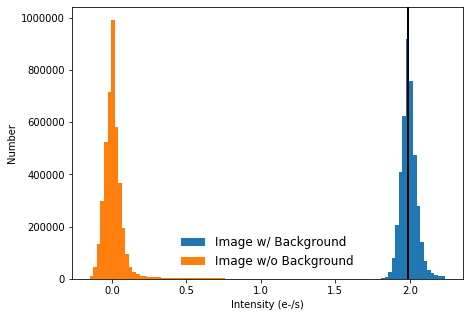

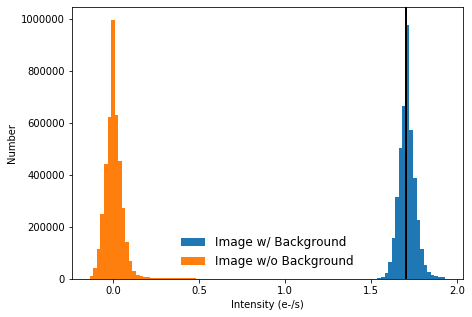

In [10]:
#***********
qa_background(img_king20_V, img_king20_V_nosky,bkg_V)
qa_background(img_king20_B, img_king20_B_nosky,bkg_B)

This routine detects stars in the image.  It requires a zero background image.  There are many ways to measure object flux.  We are using the DAOStarfinder algorithm described (https://photutils.readthedocs.io/en/stable/api/photutils.detection.DAOStarFinder.html)

This code requires as input the FWHM of stars in the image in pixel units.  You can determine this using the *imexam* task.

You can use this by going to your image directory and typing *ipython* at the command line.  Once the interactive python environment loads you type the following set of commands:

*import imexam*
*viewer=imexam.connect()*
*viewer.load_fits('<filename>')*
*viewer.scale()*
    
You can then hit the "a" key and "r" key on bright isolated and unsaturated stars to find the FWHM.

If imexam doesn't work on your computer then just use the mean FWHM from all the individual observations for that band/target

This will need to be run once for each band

In [11]:
#this code outputs a file with all the detected stars.
#fwhm is for stars in the image in units of pixels
#nsigma is the detection threshold for each star
def find_stars(image, imgfile, fwhm=3.0, nsigma=3, sigma=None, 
               verbose=True, overwrite=False):
    from astropy.table import Table
    
    #this makes a file 
    starsfile = os.path.join(redpath, 'stars-{}'.format(os.path.basename(imgfile)))
    if not os.path.isfile(starsfile) or overwrite:
        from photutils import DAOStarFinder
        if sigma is None:
            sigma = np.std(image)

        daofind = DAOStarFinder(fwhm=fwhm, threshold=nsigma * sigma)
        srcs = daofind(image)
        # reverse-sort by flux 
        srcs.sort('flux')
        srcs.reverse()
        if verbose:
            print('Found {} sources'.format(len(srcs)))

        print('Writing {} stars to {}'.format(len(srcs), starsfile))
        srcs.write(starsfile, overwrite=True)
    else:
        srcs = Table.read(starsfile)
        print('Read {} stars from {}'.format(len(srcs), starsfile))
    return srcs

In [12]:
#***********
srcs_king20_V = find_stars(img_king20_V_nosky, imgfile_king20_V, sigma=bkg_V.background_rms_median, nsigma=5, 
                  verbose=True, overwrite=False)
srcs_king20_V

Read 1356 stars from /home/c827f144/RFSLAB/USER_DPT/c827f144/ASTR596/Data/Reduced/20191104/stars-king20_V_comb.fits


id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
548,287.65722279162526,916.4953360405674,0.39045136834311023,-0.20058852262364257,0.29230940729527355,25,0.0,1191.9224555482738,2805.7151408150107,-8.620108939492688
362,2025.1806265166374,677.175135082507,0.44785544982432796,0.11245014364142134,-0.20604408831090773,25,0.0,1022.1641045372374,2597.0277713473274,-8.53619148446834
704,1501.7709251328595,1155.3248826026775,0.4426428285437429,0.09389629870412601,-0.14118452527904626,25,0.0,971.8865510173943,2352.387885095175,-8.428772335248459
721,1200.518550864298,1179.8230773692246,0.35092560269996564,0.14946642132397225,-0.1876313909090143,25,0.0,1150.767646298959,2348.339431595286,-8.426902176301233
118,1502.9092809919239,224.73499428683505,0.44415092684208657,0.2020352089682198,-0.17668709116189268,25,0.0,816.9670125102168,2007.1720989079054,-8.256461528380779
806,1549.4077037535728,1305.5382861815542,0.44471907699183,-0.050938932009051544,-0.11885187356748614,25,0.0,827.3327870621305,1997.5959443130678,-8.251269119007704
544,287.09301923582495,915.1692910472921,0.5593597941418099,-0.474286600377201,-0.12252314807126463,25,0.0,1152.7467697568875,1748.7936568290909,-8.10684642337203
545,287.97024241614054,915.5943977156412,0.3653025238550645,0.7633381065515068,0.14088804397573496,25,0.0,1180.6833239484204,1728.3501393325566,-8.094079322463696
929,1216.0450261130015,1486.4250348840958,0.4301665162236288,0.20613718716062068,-0.13217256091134558,25,0.0,632.0054651391102,1550.6755481427945,-7.976302346901138


In [13]:
srcs_king20_B = find_stars(img_king20_B_nosky, imgfile_king20_B, sigma=bkg_B.background_rms_median, nsigma=5, 
                  verbose=True, overwrite=False)
srcs_king20_B

Read 753 stars from /home/c827f144/RFSLAB/USER_DPT/c827f144/ASTR596/Data/Reduced/20191104/stars-king20_B_comb.fits


id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
287,87.05849173984979,914.2847736967841,0.41329392782110314,-0.1512946844919317,-0.22604092335171605,25,0.0,1178.0014848454412,2333.155954484322,-8.419859422968399
390,999.9675878477524,1179.0856208132468,0.4476191130470059,-0.06740090787762439,-0.13815922331225616,25,0.0,893.1468698792056,2298.969669985844,-8.403833104288168
378,1301.2622423643736,1154.7032559630823,0.4348336981976562,-0.16808819014256932,-0.11312285403002133,25,0.0,581.0682435920174,1495.2076917713102,-7.93675380627546
184,1824.9069828286842,676.7813212334947,0.4355603328167002,-0.08823550989305834,-0.13998381182744238,25,0.0,562.6225371751058,1487.572455257824,-7.931195320291073
522,1015.3820838184129,1485.6721012158569,0.44084796038852003,-0.20339417672397067,-0.15207037081983021,25,0.0,386.94821523848634,981.7243522211335,-7.479973910113756
707,789.1227717071058,1909.7561251348018,0.4481227392421155,-0.12011406191433048,-0.14381334753339078,25,0.0,368.43874018928324,971.5337077288332,-7.468644683020596
67,486.98826949464706,292.5044255763164,0.44167109680897604,-0.057956181340482166,-0.10857205221230422,25,0.0,319.66334039481296,793.3319279438389,-7.248637332459426
557,236.48274621545616,1539.3375496401684,0.44936472884959766,-0.19455725679624317,-0.22077524296454615,25,0.0,263.23783620313367,685.6166946997606,-7.090203460180609
49,1302.9101491678714,223.9912970949262,0.44502320237317916,-0.020122179451025828,-0.17357427408331816,25,0.0,231.09960571362498,610.2120294235625,-6.963701912153133


<h3> Use stars from Pan-STARRS</h3>

We will be using the large survey called Pan-STARRS (https://panstarrs.stsci.edu/).  Pan-STARRS uses SDSS filters (*griz*), which are different from the "Johnson" *BVR* filters that we are using.  But there are transformation between these filters such that if we know the Pan-STARRS magnitudes of a given object, we can determine its B-V color.

This routine sends a request to a catalog server at a remote location and pulls back all the photometry

In [14]:
def get_panstarrs_catalog(imgwcs, radius=0.2, rfaint=17, region=False):
    from astroquery.mast import Catalogs
    ra0, dec0 = imgwcs.wcs.crval
    print('Querying Pan-STARRS catalog with radius={:.3f} deg and central coordinates RA,Dec={:.5f},{:.5f}'.format(
        radius, ra0, dec0))
    if region:
        allcat = Catalogs.query_region('{} {}'.format(ra0, dec0), radius=radius,
                                       catalog='PANSTARRS', data_release='dr2', 
                                       table='mean')#, rMeanPSFMag=[12, 22])
    else:
        allcat = Catalogs.query_criteria(coordinates='{} {}'.format(ra0, dec0), radius=radius,
                                         catalog='PANSTARRS', data_release='dr2', 
                                         table='mean',
                                         columns=['objID', 'raMean', 'decMean',
                                                  'gMeanPSFMag', 'rMeanPSFMag', 'iMeanPSFMag', 'zMeanPSFMag'],
                                         gMeanPSFMag=[('lte', 18), ('gte', 12)],
                                         rMeanPSFMag=[('lte', 18), ('gte', 12)],
                                         iMeanPSFMag=[('lte', 18), ('gte', 12)],
                                         zMeanPSFMag=[('lte', 18), ('gte', 12)],
                                         sort_by=[("asc", "rMeanPSFMag")])
    

    #we limit ourselves to bright objects so that we know that they will have high Signal-to-Noise
    rmag = allcat['rMeanPSFMag']
    good = np.isfinite(rmag) * rmag < rfaint
    cat = allcat[good]
    print('Keeping {}/{} Pan-STARRS sources with rmag< {}.'.format(len(cat), len(allcat),rfaint))
    
    #make B and V-band magnitudes using the transformations published in Tonry et al. (2012)
    #https://ui.adsabs.harvard.edu/abs/2012ApJ...750...99T/abstract
    cat['B'] = 0.213 + 0.587 * (cat['gMeanPSFMag'] - cat['rMeanPSFMag']) + cat['gMeanPSFMag'] 
    cat['V'] = 0.006 + 0.474 *  (cat['gMeanPSFMag'] - cat['rMeanPSFMag']) + cat['rMeanPSFMag'] 
    
    return cat

In [15]:
%time refcat_king20_V = get_panstarrs_catalog(imgwcs_king20_V, radius=0.2)
refcat_king20_V

Querying Pan-STARRS catalog with radius=0.200 deg and central coordinates RA,Dec=353.35764,58.47558


Keeping 649/661 Pan-STARRS sources with rmag< 17.
CPU times: user 332 ms, sys: 56.4 ms, total: 389 ms
Wall time: 12.3 s


objID,raMean,decMean,gMeanPSFMag,rMeanPSFMag,iMeanPSFMag,zMeanPSFMag,B,V
int64,float64,float64,float64,float64,float64,float64,float64,float64
177973533643142604,353.36438085,58.30983231,12.566200256347656,12.007800102233887,13.251099586486816,12.253600120544434,13.106981146812439,12.278481775283813
178253534222408649,353.42222936,58.54832542,13.094300270080566,12.312999725341797,13.089300155639648,12.481800079345703,13.765923689842225,12.689336183547974
178063533638825273,353.3639764,58.38714689,12.656000137329102,12.395000457763672,12.265000343322754,12.16100025177002,13.02220694923401,12.524714305877685
178193533621090461,353.36215886,58.49157593,13.093000411987305,12.541000366210938,12.26200008392334,12.09000015258789,13.630024438858031,12.808648387908935
178003535709165660,353.57091598,58.33742606,12.979000091552734,12.571000099182129,12.34000015258789,12.159000396728516,13.43149608707428,12.770392095565796
178243534353808280,353.43544285,58.53951268,13.38700008392334,12.699000358581543,12.326000213623047,12.074000358581543,14.003855922698975,13.031112228393555
177943533354839104,353.33555251,58.2904111,14.216699600219727,12.987000465393066,12.402000427246094,12.01200008392334,15.151532992362975,13.575877855300904
178283534833775064,353.48342907,58.57027888,13.446000099182129,13.022000312805176,12.788000106811523,12.595000267028809,13.9078879737854,13.228976211547852
178203532822397719,353.28226479,58.50580757,13.437000274658203,13.062000274658203,12.831000328063965,12.675000190734863,13.870125274658204,13.245750274658203


In [16]:
%time refcat_king20_B = get_panstarrs_catalog(imgwcs_king20_B, radius=0.2)
refcat_king20_B

Querying Pan-STARRS catalog with radius=0.200 deg and central coordinates RA,Dec=353.31941,58.47552
Keeping 643/652 Pan-STARRS sources with rmag< 17.
CPU times: user 26.1 ms, sys: 214 µs, total: 26.3 ms
Wall time: 2.83 s


objID,raMean,decMean,gMeanPSFMag,rMeanPSFMag,iMeanPSFMag,zMeanPSFMag,B,V
int64,float64,float64,float64,float64,float64,float64,float64,float64
177973533643142604,353.36438085,58.30983231,12.566200256347656,12.007800102233887,13.251099586486816,12.253600120544434,13.106981146812439,12.278481775283813
178253534222408649,353.42222936,58.54832542,13.094300270080566,12.312999725341797,13.089300155639648,12.481800079345703,13.765923689842225,12.689336183547974
178063533638825273,353.3639764,58.38714689,12.656000137329102,12.395000457763672,12.265000343322754,12.16100025177002,13.02220694923401,12.524714305877685
178193533621090461,353.36215886,58.49157593,13.093000411987305,12.541000366210938,12.26200008392334,12.09000015258789,13.630024438858031,12.808648387908935
178003535709165660,353.57091598,58.33742606,12.979000091552734,12.571000099182129,12.34000015258789,12.159000396728516,13.43149608707428,12.770392095565796
178243534353808280,353.43544285,58.53951268,13.38700008392334,12.699000358581543,12.326000213623047,12.074000358581543,14.003855922698975,13.031112228393555
177973531027574158,353.10279647,58.31128974,13.32800006866455,12.699000358581543,12.366000175476074,12.145000457763672,13.910222898483276,13.003146221160888
177943533354839104,353.33555251,58.2904111,14.216699600219727,12.987000465393066,12.402000427246094,12.01200008392334,15.151532992362975,13.575877855300904
178283534833775064,353.48342907,58.57027888,13.446000099182129,13.022000312805176,12.788000106811523,12.595000267028809,13.9078879737854,13.228976211547852


We need to match the Pan-STARRS catalog against ours.  First we need to compute the nearest Pan-STARRS star to each of ours and look at the distribution of distances to find the optimal match.

In [17]:
def sep_check(imgwcs,srcs,refcat):
    import astropy.units as u
    from astropy.coordinates import SkyCoord
    
    #this makes an instance of a SkyCoord class containing the RAs and Decs from Pan-STARRS objects
    refcoord = SkyCoord(ra=refcat['raMean']*u.deg, dec=refcat['decMean']*u.deg)
    #This uses the WCS to convert the x and y positions of stars in our image to RA-DEC
    radec_stars = imgwcs.all_pix2world(srcs['xcentroid']+1, srcs['ycentroid']+1, 1)
    #this does the same from our targets 
    coord = SkyCoord(ra=radec_stars[0]*u.deg, dec=radec_stars[1]*u.deg)

    #this calculates the separations.  The "_" are values that are thrown away
    _, sep2d, _ = coord.match_to_catalog_sky(refcoord)

    #plot the histograms
    _ = plt.hist(sep2d.arcsec, bins=100, range=(-0.5, 3))
    return refcoord, coord

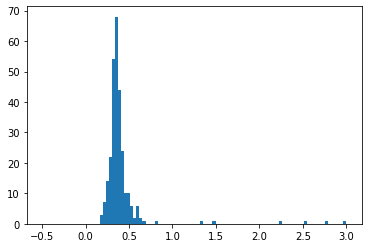

In [18]:
refcoord_king20_V, coord_king20_V = sep_check(imgwcs_king20_V,srcs_king20_V,refcat_king20_V)

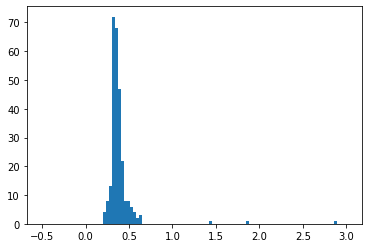

In [19]:
refcoord_king20_B, coord_king20_B = sep_check(imgwcs_king20_B,srcs_king20_B,refcat_king20_B)

It looks like the optimal match is less than 1.0 arcsec.  The following routine matches to within this tolerance

In [20]:
#take two lists of coordinates 
import astropy.units as u
def match_src_ref(refcoord, coord, srcs, img, radasec = 1.0):
    rad = radasec * u.arcsec

    #find the indices of the reference and source list that correspond to matching objects such that
    #the first index in each list corresponds to the first matching object
    indx_ref, indx, d2d, _ = coord.search_around_sky(refcoord, rad)
    nmatch = len(indx_ref)
    print('Found {}/{} stars within {}'.format(nmatch, len(srcs), rad))
    display_image(img, srcs=srcs[indx], calibrated=True)
    return indx, indx_ref

Found 274/1356 stars within 1.0 arcsec
Found 265/753 stars within 1.0 arcsec


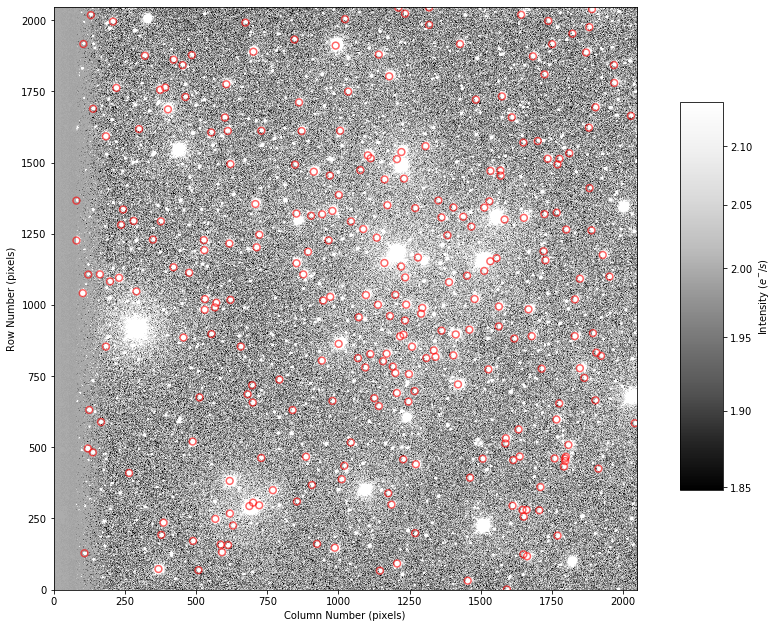

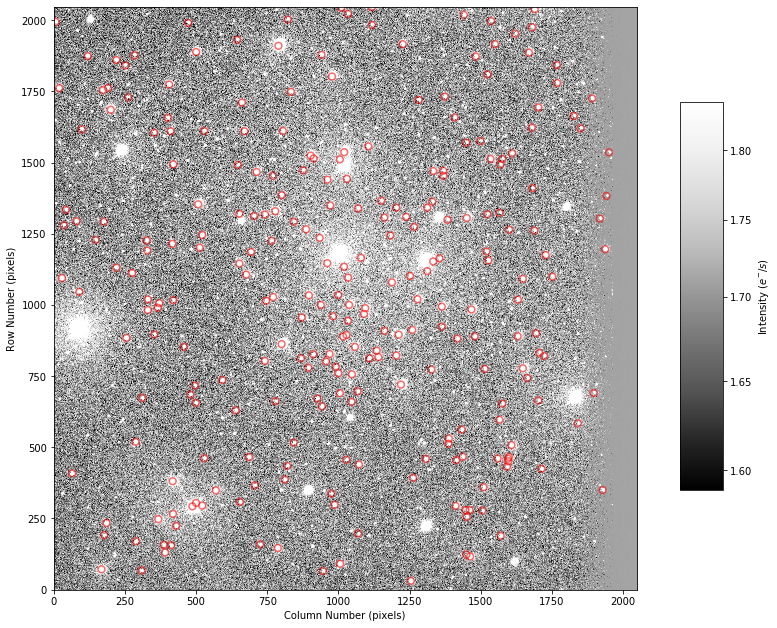

In [21]:
indx_king20_V, indx_ref_king20_V = match_src_ref(refcoord_king20_V, coord_king20_V, srcs_king20_V, img_king20_V)
indx_king20_B, indx_ref_king20_B = match_src_ref(refcoord_king20_B, coord_king20_B, srcs_king20_B, img_king20_B)

Now let's calculate the zeropoints for each image.  To compare our objects to those from Pan-STARRS we will need to correct for the effects of airmass.

We start by specifying the atmospheric extinction coefficient for each object.  This says for a typical atmosphere, how much the magnitude changes for an increase in airmass of 1.  We could have measured this using mutliple standard stars but will just assume a cannonical value for now.

In [22]:
def zp_meas(srcs, refcat, indx, indx_ref, hdr):
    kext = {'B': 0.4, 'V': 0.2}
    import numpy.ma as ma

    #this consists of the instrumental magnitude, which is the magnitude, including an airmass correction
    #but without a true zeropoint.  The second term says how the magnitude 
    #m(inst) = -2.5 * log(flux) - (sec z) * k
    instmag = srcs['mag'][indx].data - hdr['AIRMASS'] * kext[hdr['FILTER']]

    #the Pan-STARRS magnitudes for the same objects, as indicated using the indx_ref array
    psmag = refcat[hdr['FILTER']][indx_ref].data

    #calculate the median zeropoint defined as
    #psmag = -2.5 * log(flux) - (sec z) * k + ZP = m(inst) + ZP
    medzp = np.median(psmag - instmag)
    print(hdr['FILTER'],'zeropoint = ', medzp)
    print('Airmass in {} was {}'.format(hdr['FILTER'], hdr['AIRMASS']))
    return medzp

In [23]:
ZPV = zp_meas(srcs_king20_V,refcat_king20_V, indx_king20_V, indx_ref_king20_V,hdr_king20_V)
ZPB = zp_meas(srcs_king20_B,refcat_king20_B, indx_king20_B, indx_ref_king20_B,hdr_king20_B)

V zeropoint =  20.498199462624385
Airmass in V was 1.144451
B zeropoint =  21.027674747115967
Airmass in B was 1.129516


/home/c827f144/.conda/envs/obs/lib/python3.7/site-packages/numpy/core/fromnumeric.py:734: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Now match the B and V-band catalogs together for this cluster, apply the zeropoints, and plot a CMD!

In [26]:
def make_CMD(img_B,imgwcs_B,srcs_B,imgwcs_V,srcs_V, hdr_B, hdr_V, ZPB, ZPV, radasec = 1.0):
    import astropy.units as u
    from astropy.coordinates import SkyCoord
    import numpy.ma as ma
    kext = {'B': 0.4, 'V': 0.2}
    rad = radasec * u.arcsec
    
    #This uses the WCS to convert the x and y positions of stars in our image to RA-DEC
    radec_stars_B = imgwcs_B.all_pix2world(srcs_B['xcentroid']+1, srcs_B['ycentroid']+1, 1)
    radec_stars_V = imgwcs_V.all_pix2world(srcs_V['xcentroid']+1, srcs_V['ycentroid']+1, 1)
    #this makes an instance of a SkyCoord class containing the RAs and Decs from the B-band
    coord_B = SkyCoord(ra=radec_stars_B[0]*u.deg, dec=radec_stars_B[1]*u.deg)
    coord_V = SkyCoord(ra=radec_stars_V[0]*u.deg, dec=radec_stars_V[1]*u.deg)

    #this calculates the separations.  The "_" are values that are thrown away
    _, sep2d, _ = coord_B.match_to_catalog_sky(coord_V)

    #plot the histograms
    _ = plt.hist(sep2d.arcsec, bins=100, range=(-0.5, 3))
    plt.xlabel('Sep between B and V sources [arcsec]',fontsize=14)
    plt.ylabel('N',fontsize=14)


    #find the indices of the reference and source list that correspond to matching objects such that
    #the first index in each list corresponds to the first matching object
    indx_B, indx_V, d2d, _ = coord_V.search_around_sky(coord_B, rad)
    nmatch = len(indx_B)
    print('Found {}/{} stars within {}'.format(nmatch, len(srcs_B), rad))
    display_image(img_B, srcs=srcs_B[indx_B], calibrated=True)
    
    #make the B and V-band magnitudes
    magB = srcs_B['mag'][indx_B].data + ZPB - hdr_B['AIRMASS'] * kext[hdr_B['FILTER']]
    magV = srcs_V['mag'][indx_V].data + ZPV - hdr_V['AIRMASS'] * kext[hdr_V['FILTER']]
    #print(magB)
    #print(magV)
    for i in range(0, len(magB)):
        # color, magnitude, ra, dec
        print((magB-magV)[i], (magV)[i], coord_B[i].ra, coord_B[i].dec)
    #print((magB-magV)[0], coord_B[0].ra)

    #plot the CMD!
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.plot(magB-magV, magV, 'ro',alpha=0.7)
    ax.set_ylim(19,10)
    ax.set_xlabel('B-V',fontsize=18)
    ax.set_ylabel('V',fontsize=18)
    plt.show


Found 723/753 stars within 1.0 arcsec
0.5068086010158712 11.649200323131696 353d29m53.1838s 58d29m10.2484s
-0.0064539151047871 12.162462839252354 353d19m25.8788s 58d27m36.0277s
-0.019221016013121428 12.175229940160689 353d15m59.1339s 58d27m44.8528s
0.32962815650464705 11.842407086323151 353d09m59.5526s 58d30m36.288s
0.7985776134645803 11.840536927375926 353d19m14.9653s 58d25m45.983s
0.9115552486688472 11.733117778156045 353d21m49.4126s 58d23m13.6276s
0.8028875212789632 12.293006915723247 353d25m19.55s 58d32m53.8504s
0.7373521955155873 12.369871468579783 353d28m08.9918s 58d25m26.0986s
0.7369498690570833 12.590281145599457 353d15m58.2708s 58d33m18.8756s
1.1886496774282893 12.297015209507068 353d21m43.371s 58d29m29.6133s
1.5993187007192269 12.012847734243605 353d15m26.4463s 58d26m50.9447s
0.8865559186212444 12.977024952920571 353d20m42.2293s 58d32m33.736s
1.942554237172855 12.01804014361668 353d26m07.0262s 58d32m22.1229s
1.4868979420722948 12.603237383158426 353d16m55.5394s 58d30m20.8015s

1.2184539121061153 15.999697675973147 353d15m56.0592s 58d31m54.5196s
1.2432906780545139 16.002660461938802 353d30m09.9721s 58d32m11.7404s
1.3961347484594189 15.861026554749495 353d30m44.8791s 58d22m42.7711s
1.3421235657838988 15.929946606111846 353d19m05.3946s 58d26m01.4512s
1.735007860508011 15.576617125952621 353d29m28.3535s 58d23m25.9499s
1.2442802901610541 16.079910309146257 353d27m06.7227s 58d27m31.2322s
1.290492997787215 16.036897595822253 353d27m36.3089s 58d31m32.3773s
0.965192754869598 16.389570719144835 353d11m40.2485s 58d24m57.0653s
1.4539341241649186 15.941791246098875 353d28m51.3381s 58d26m54.7123s
1.4200872079644746 16.00183845754387 353d14m29.4156s 58d31m17.5437s
1.3030392226820133 16.11991938664129 353d14m26.6172s 58d31m51.6645s
1.0171067527589166 16.410753901300087 353d26m09.5829s 58d25m01.0769s
1.1489834161351844 16.301786953184646 353d12m27.5452s 58d25m29.3363s
1.1695042662673956 16.28333971312195 353d18m55.2109s 58d30m42.5212s
1.3647020608066782 16.099594445425783 35

1.3220527976877925 17.392309125934585 353d22m23.6595s 58d23m50.3417s
1.1965087662318368 17.5246211664639 353d27m51.2561s 58d24m18.151s
1.0610637066227113 17.695342016998495 353d29m10.6956s 58d27m17.6887s
1.1045794452910158 17.67262495813386 353d11m38.7455s 58d26m13.3011s
1.2417624877890496 17.543295102049775 353d23m34.865s 58d30m52.9891s
1.4156608312449137 17.388129450593826 353d12m42.767s 58d25m23.0513s
1.2804786501363914 17.55324983752443 353d18m39.085s 58d33m28.2969s
1.3296759842357062 17.507968497716345 353d15m17.2482s 58d29m07.728s
1.3020893081043567 17.53769276602081 353d19m00.2665s 58d30m18.5512s
1.271831889905485 17.57244321337212 353d24m18.7622s 58d25m11.5023s
1.2757951155377256 17.573136824595164 353d17m20.8807s 58d27m12.889s
1.9739177793055482 16.879061327164447 353d21m58.5122s 58d30m41.5435s
1.1413245960263687 17.713241993768026 353d17m00.5955s 58d25m41.0915s
1.10609416713503 17.758186263979063 353d12m58.5919s 58d22m51.2692s
1.1830846609710655 17.683345848246947 353d23m24.6

1.2730300104437404 18.302575942628113 353d22m31.8662s 58d28m14.2252s
1.1689274434420618 18.421434353848525 353d14m36.2922s 58d24m50.0406s
1.1399452941609738 18.45448820280349 353d24m09.5073s 58d32m52.6307s
1.4265146698972266 18.16866386456623 353d21m15.1369s 58d27m13.1946s
0.9322140249072497 18.667169561737655 353d20m30.4109s 58d23m17.7908s
1.4433707651216245 18.156353351014964 353d27m41.7724s 58d31m37.4745s
1.4446445360291946 18.1574749111219 353d16m27.5205s 58d26m44.0214s
1.3927986708904392 18.212088541281155 353d17m23.312s 58d31m12.1413s
1.747863332897655 17.857331639775925 353d10m36.1359s 58d24m41.9758s
1.383755163457824 18.225886064026675 353d15m29.944s 58d33m23.0173s
1.2640314245072375 18.363674086742666 353d16m55.1873s 58d29m16.0243s
1.1998595149043538 18.42843953672094 353d24m09.2913s 58d22m59.5234s
1.4057206616414177 18.223692919204492 353d27m40.5365s 58d30m00.08s
1.8771236639993205 17.75614048076158 353d26m08.8012s 58d27m19.0858s
1.2251283843398646 18.412504370219775 353d15m3

1.2608726438807807 19.16154433287397 353d08m28.283s 58d26m02.1636s
1.2474899516788192 19.17592833217246 353d13m18.9079s 58d29m43.7277s
1.1762078673543712 19.249707887865117 353d17m11.4243s 58d30m11.5371s
0.983170012465326 19.444463356164647 353d08m57.3559s 58d22m40.5708s
1.5123650745972128 18.91946148955113 353d13m38.0363s 58d24m01.3825s
1.15098766977356 19.28269697994106 353d12m10.6774s 58d29m04.5032s
1.2108091877639389 19.229654891399832 353d22m52.5374s 58d30m19.2374s
1.3993706356062816 19.04167158990376 353d27m30.4995s 58d27m32.9683s
0.9991424138954734 19.44510125697006 353d11m26.7085s 58d33m28.5769s
1.694199265506949 18.751734371624416 353d21m17.8412s 58d34m06.962s
1.3044256106128067 19.141973169529425 353d24m50.9951s 58d30m28.0516s
1.578191245831647 18.868465960694746 353d11m08.2343s 58d28m28.071s
1.2589249161605878 19.190715096897307 353d30m13.1716s 58d26m09.5014s
1.2242718210363286 19.227329099746363 353d28m38.9737s 58d29m18.7462s
0.7462912849760599 19.705887506063682 353d16m21.

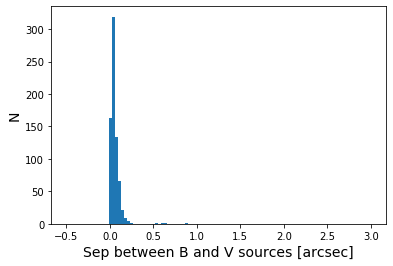

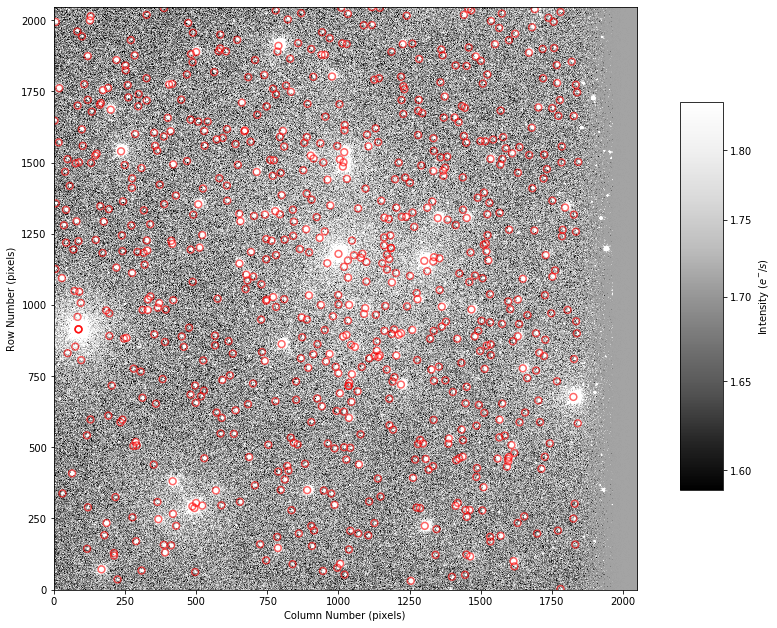

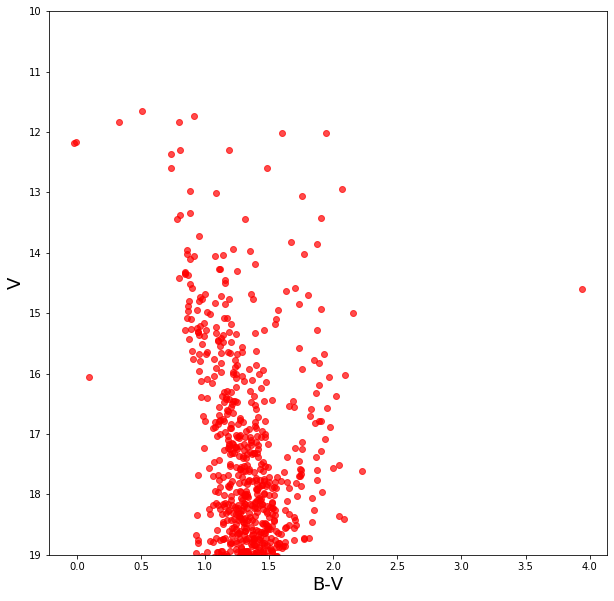

In [27]:
make_CMD(img_king20_B, imgwcs_king20_B, srcs_king20_B,imgwcs_king20_V, srcs_king20_V, hdr_king20_B, hdr_king20_V, ZPB, ZPV, radasec = 1.0)

Star comparison:
<br><br>
0142
<br>RA:353d15m17  Dec:58d29m07
<br>WebdaV:17.422  WebdaB-V:1.194 
<br>OurV:17.508  OurB-V:1.330
<br><br>
0185
<br>RA:353d19m39.6  Dec:58d28m54.6
<br>WebdaV:16.822  WebdaB-V:1.210
<br>OurV:17.004  OurB-V:1.115
<br><br>
0141
<br>RA:353d18m48.5  Dec:58d27m37.7
<br>WebdaV:17.943 WebdaB-V:1.421
<br>OurV:18.019  OurB-V:1.330

To find this data, I manually found stars in the image, got their RAs and Decs, and then found those in both the Webda dataset and the above list of output values. I then compared the two sets of magnitudes and colors, and honestly they seem pretty close to the accepted values. The difference in our CMD is likely due to the different scales of the diagrams and our non-filtering of background noise.